# Kalman Sandbox

Testing the basic Kalman filter for linear system where:

$y_t = \alpha + \beta_t x_t + \epsilon_t$

$\beta_t = \bf F \beta_{t-1}$

We will simulate $x_t$ to have normal variances $N(1, 10)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from filterpy.kalman import KalmanFilter

In [2]:
betas1 = [3 for i in range(50)] + [6 for i in range(50)]
x = [np.random.normal(1, 2) for i in range(100)]
y1 = np.array(x) * np.array(betas1) + np.array([np.random.normal(0, 0.1) for i in range(len(x))])

In [3]:
class KF:
    def __init__(self, x0, lags=0):
        self.lags = lags
        kf = KalmanFilter(dim_x=lags+2, dim_z=lags+2)
        kf.x = x0
        kf.Q = 0
        self.kf = kf
        self.xs = {i: [] for i in range(self.lags+2)}
        self.kf.P = np.diag([50, 50])
        self.kf.R = np.diag([0.1, 0.1])
        self.kf.F = np.array([[1,1], [1,1]])
    
    def run(self, y_col, x_col, df):        
        # run filter
        for i in range(1, len(df)):
            self.kf.H = np.array([[1] + [df.shift(j).iloc[i][f'{x_col}'] for j in range(self.lags+1)], 
                                 [1] + [df.shift(j).iloc[i-1][f'{x_col}'] for j in range(self.lags+1)]]) # update H with fresh values
            self.kf.update(np.array([df.iloc[i][f'{y_col}'], df.iloc[i-1][f'{y_col}']]))
            for j in range(self.lags+2):
                self.xs[j].append(self.kf.x[j])
                
        return pd.DataFrame(self.xs)

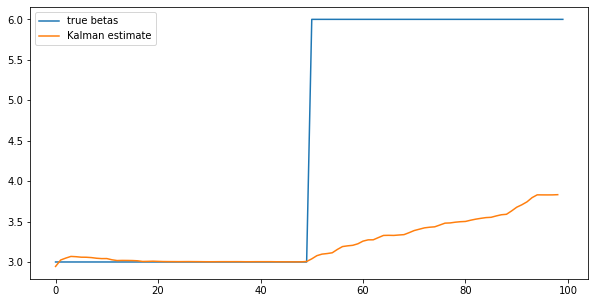

In [4]:
x0 = np.array([1, 1])
kf = KF(x0).run('y', 'x', pd.DataFrame({'y': y1, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas1, label='true betas')
plt.plot(kf[1], label='Kalman estimate')
plt.legend()

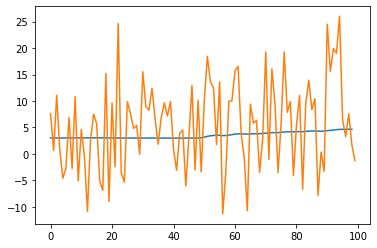

In [5]:
kf.sum(axis=1).plot()
plt.plot(y1)

In [6]:
betas2 = [i * np.random.normal(1, 10) for i in range(100)]
y2 = np.array(x) * np.array(betas2) + np.array([np.random.normal(0, 10) for i in range(len(x))])

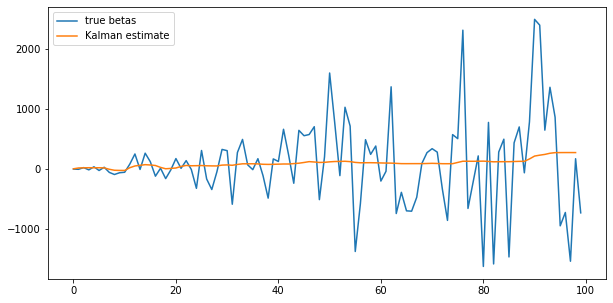

In [7]:
kf2 = KF(x0).run('y', 'x', pd.DataFrame({'y': y2, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas2, label='true betas')
plt.plot(kf2[1], label='Kalman estimate')
plt.legend()

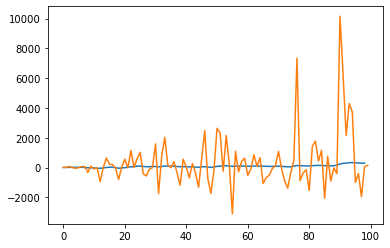

In [8]:
kf2.sum(axis=1).plot()
plt.plot(y2)

Finally we simulate a trend.

In [9]:
betas3 = [100 + i + np.random.normal(1, 10) for i in range(100)]
y3 = np.array(x) * np.array(betas3) + np.array([np.random.normal(0, 10) for i in range(len(x))])

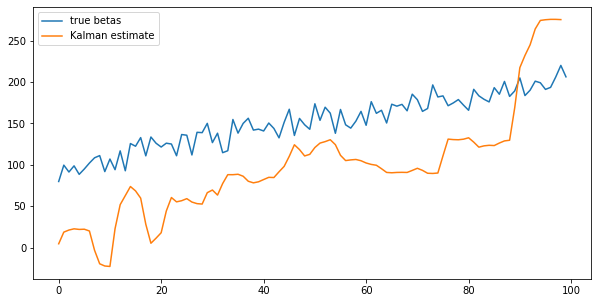

In [10]:
kf3 = KF(x0).run('y', 'x', pd.DataFrame({'y': y3, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas3, label='true betas')
plt.plot(kf2[1], label='Kalman estimate')
plt.legend()

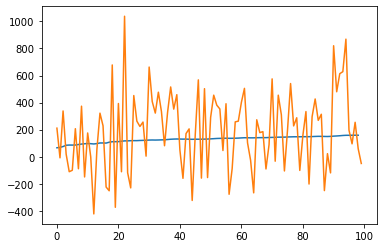

In [11]:
kf3.sum(axis=1).plot()
plt.plot(y3)

It seems that the short term rolling window is far more prone to noise, and a longer-term measurement sample allows a better fit to the underlying trend.